#### Comparing Reference Data ####

**Ensure that you are in the root of tardis-refdata!**

The use the comparer to load the reference data. Use teardown to delete the reference data afterwards

In [1]:
from __future__ import print_function
import pandas as pd
import subprocess
import tempfile
import shlex, os, shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cd ..

/home/epassaro/Desktop/tardis-sn/tardis-refdata


In [3]:
pwd # you should be in the root

'/home/epassaro/Desktop/tardis-sn/tardis-refdata'

In [4]:
def highlight_missing(val):
    if val == True:
        return 'background-color: #BCF5A9'
    else:
        return 'background-color: #F5A9A9'
    
def highlight_relative_difference(val):
    ret = 'background-color: #BCF5A9'
    if val is None:
        ret = 'background-color: #BCF5A9'
    elif val > 1e-2:
        ret = 'background-color: #F2F5A9'
    elif val > 1e-1:
        ret = 'background-color: #F5D0A9'
    elif val > 1:
        ret = 'background-color: #F5A9A9'
    return ret

In [5]:
class ReferenceComparer(object):

    def __init__(self, ref1_hash=None, ref2_hash=None, compare_path='unit_test_data.h5'):
        assert not ((ref1_hash is None) and (ref2_hash is None)), "One hash can not be None"
        self.ref1_hash = ref1_hash
        self.ref2_hash = ref2_hash
        self.compare_path = compare_path
        #subprocess.Popen('git --work-tree=/Users/wkerzend/tmp/ checkout upstream/pr/8 {cpath}', shell=True)
        self.tmp_dir = None
        self.setup()
    
    def setup(self):
        self.tmp_dir = tempfile.mkdtemp()
        print('Created temporary directory at {0}. Delete after use with .teardown'.format(self.tmp_dir))
        for ref_id, ref_hash in enumerate([self.ref1_hash, self.ref2_hash]):
            ref_id += 1
            if ref_hash is not None:
                self._copy_data_from_hash(ref_hash, 'ref{0}_'.format(ref_id))
            else:
                subprocess.Popen('cp {0} {1}'.format(self.compare_path, 
                                                     os.path.join(self.tmp_dir, 
                                                                  'ref{0}_{1}'.format(ref_id, self.compare_path))), 
                                                     shell=True)
            setattr(self, 'ref{0}_fname'.format(ref_id), 
                    os.path.join(self.tmp_dir, 'ref{0}_{1}'.format(ref_id, self.compare_path)))
    def teardown(self):
        shutil.rmtree(self.tmp_dir)
    def _copy_data_from_hash(self, ref_hash, prefix):
        git_cmd = ['git']
        git_cmd.append('--work-tree={0}'.format(self.tmp_dir))
        git_cmd += ['checkout', ref_hash, self.compare_path]
        p = subprocess.Popen(git_cmd)
        p.wait()
        shutil.move(os.path.join(self.tmp_dir, self.compare_path), 
                    os.path.join(self.tmp_dir, prefix + self.compare_path))

    def generate_test_table(self):
        rd1_hdfs = pd.HDFStore(self.ref1_fname, mode='r')
        rd2_hdfs = pd.HDFStore(self.ref2_fname, mode='r')
        rd1_keys = rd1_hdfs.keys()
        rd2_keys = rd2_hdfs.keys()
        rd1_hdfs.close()
        rd2_hdfs.close()
        rd1_df = pd.DataFrame(index=rd1_keys, columns=['exists'])
        rd2_df = pd.DataFrame(index=rd2_keys, columns=['exists'])
        rd1_df['exists'] = True
        rd2_df['exists'] = True
        joined_df = rd1_df.join(rd2_df, how='outer', lsuffix='_1', rsuffix='_2')
        joined_df = joined_df.fillna(False)
        return joined_df
    
    def compare_refdata(self, test_table):
        test_table['match'] = None
        test_table['abs_diff_mean'] = None
        test_table['abs_diff_max'] = None
        test_table['rel_diff_mean'] = None
        test_table['rel_diff_max'] = None
        for row_id, row in test_table.iterrows():
            if row[['exists_1', 'exists_2']].all():
                ref1_df = pd.read_hdf(self.ref1_fname, row_id)
                ref2_df = pd.read_hdf(self.ref2_fname, row_id)
                if isinstance(ref1_df, pd.Series):
                    try:
                        pd.util.testing.assert_series_equal(ref1_df, ref2_df)
                    except AssertionError:
                        test_table.loc[row_id, 'match'] = False
                        abs_diff = np.fabs(ref1_df - ref2_df)
                        rel_diff = (abs_diff / np.fabs(ref1_df))[ref1_df != 0]
                        test_table.loc[row_id, 'abs_diff_mean'] = abs_diff.mean()
                        test_table.loc[row_id, 'abs_diff_max'] = abs_diff.max()
                        test_table.loc[row_id, 'rel_diff_mean'] = rel_diff.mean()
                        test_table.loc[row_id, 'rel_diff_max'] = rel_diff.max()
                    else:
                        test_table.loc[row_id, 'match'] = True

                elif isinstance(ref1_df, pd.DataFrame):
                    try:
                        pd.util.testing.assert_frame_equal(ref1_df, ref2_df)
                    except AssertionError:
                        test_table.loc[row_id, 'match'] = False
                        abs_diff = np.fabs(ref1_df - ref2_df)
                        rel_diff = (abs_diff / np.fabs(ref1_df))[ref1_df != 0]
                        test_table.loc[row_id, 'abs_diff_mean'] = abs_diff.mean(skipna=True).mean()
                        test_table.loc[row_id, 'abs_diff_max'] = abs_diff.max(skipna=True).max()
                        test_table.loc[row_id, 'rel_diff_mean'] = rel_diff.mean(skipna=True).mean()
                        test_table.loc[row_id, 'rel_diff_max'] = rel_diff.max(skipna=True).max()
                    else:
                        test_table.loc[row_id, 'match'] = True

                else:
                    raise ValueError('Needs to be a Series or DataFrame but is' + str(type(ref1_df)))
        return test_table
                

In [6]:
#you can add ref1_hash and ref2_hash. If either is set to None it will just use the current data in the directory
# other than that you can use any git label (e.g. hash, tag, branch name)
comparer = ReferenceComparer(ref2_hash='upstream/pr/24')

Created temporary directory at /tmp/tmpfh0bj_aj. Delete after use with .teardown


In [7]:
#comparer.teardown() -  only run after the comparison

In [8]:
tt = comparer.generate_test_table()

In [9]:
tt = comparer.compare_refdata(tt)

In [10]:
tt[["exists_1", "exists_2", 'rel_diff_mean', 'rel_diff_max']].style.applymap(
    highlight_missing, subset=['exists_1', 'exists_2', 'match']).applymap(
    highlight_relative_difference, subset=['rel_diff_mean', 'rel_diff_max'])

/home/epassaro/miniconda3/envs/tardis/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


## Detailed Inspection of the Reference Data

If parts of the reference data show differences between revisions, you should invest some time examining these differences in detail. Often, visualizing the relevant data blocks already helps. You can use the following plotting routines as a blueprint and adjust and extend them to your needs.

In [11]:
def compare_output_nu(df1, df2):
    nu_min = np.min([df1.min(), df2.min()])
    nu_max = np.max([df1.max(), df2.max()])
    
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    plt.plot(df1, df2, ',')
    plt.xlabel("output_nu, ref 1")
    plt.ylabel("output_nu, ref 2")
    plt.subplot(122)
    plt.hist(df1, bins=np.linspace(nu_min, nu_max, 100), histtype="step", label="ref 1")
    plt.hist(df2, bins=np.linspace(nu_min, nu_max, 100), histtype="step", label="ref 2")
    plt.xlabel("output_nu")
    plt.legend(frameon=False)
    
def compare_spectrum(ref1_nu, ref1_L, ref2_nu, ref2_L):
    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    plt.plot(ref1_nu, ref1_L, label="ref 1")
    plt.plot(ref2_nu, ref2_L, label="ref 2")
    plt.xlabel("nu")
    plt.ylabel("L")
    plt.legend(frameon=False)
    plt.subplot(122)
    plt.plot(ref1_nu, ref1_L / ref2_L)
    plt.xlabel("nu")
    plt.ylabel("L ref 1 / L ref 2")

Get the data and find all the entries for which differences exist

In [12]:
tmp1 = pd.HDFStore(comparer.ref1_fname, "r")
tmp2 = pd.HDFStore(comparer.ref2_fname, "r")

diff_entries = tt.loc[(tt["match"] == False) & (tt["exists_1"] == True) & (tt["exists_2"] == True)].index

Start the visual exploration

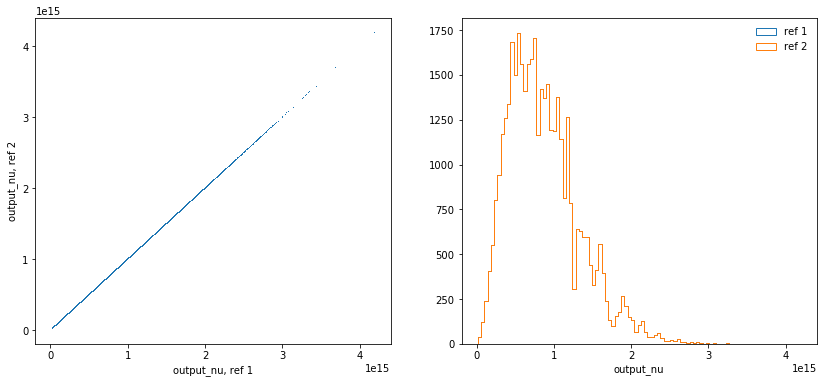

In [13]:
compare_output_nu(tmp1['/test_simulation/output_nu'], tmp2['/test_simulation/output_nu'])

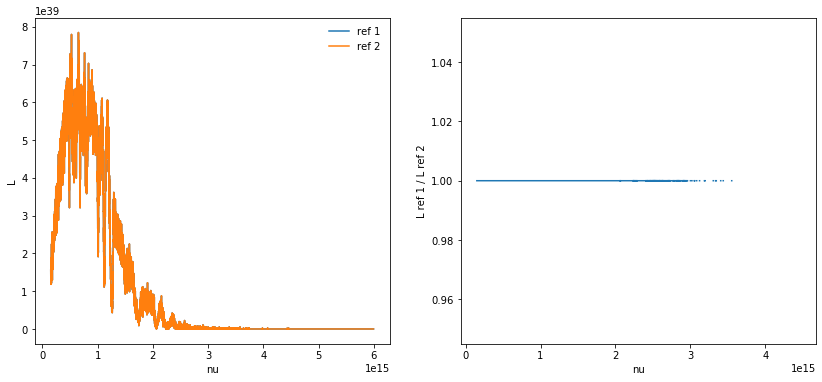

In [14]:
compare_spectrum(tmp1['/test_runner_simple/spectrum/_frequency'][:-1], 
                 tmp1['/test_runner_simple/spectrum/luminosity'],
                 tmp2['/test_runner_simple/spectrum/_frequency'][:-1], 
                 tmp2['/test_runner_simple/spectrum/luminosity'])